# Tracking highly motile cells using flow field estimation and Ultrack

Tracking highly motile cells can be challenge. Here wee show how you can estimate the flow of cells to assist with tracking motile cells.

For this purpose we analyise the Tribolium Castaneum embryo 3D cartographic projection from the [cell tracking challenge](http://celltrackingchallenge.net/3d-datasets), the cells in this dataset show a clear migration pattern, their movement are further amplified on the vertical edges of the image due to projection artifacts.

First, we download the data from their website.

In [1]:
!wget -nc http://data.celltrackingchallenge.net/training-datasets/Fluo-N3DL-TRIC.zip
!unzip -n Fluo-N3DL-TRIC.zip

File ‘Fluo-N3DL-TRIC.zip’ already there; not retrieving.

Archive:  Fluo-N3DL-TRIC.zip


We import the required packages. You can install them using the conda environment file on this folder.

In [2]:
from pathlib import Path

import napari
import numpy as np
import zarr
import dask.array as da
import scipy.ndimage as ndi
from napari.utils.notebook_display import nbscreenshot
from rich.pretty import pprint

from ultrack import MainConfig, add_flow, segment, link, solve, to_tracks_layer, tracks_to_zarr
from ultrack.imgproc import array_apply, create_zarr, robust_invert, detect_foreground
from ultrack.imgproc.flow import timelapse_flow, advenct_field_from_labels, trajectories_to_tracks

We set the download dataset path, open a napari viewer and open the images using napari's default reader.

We restrict our selves to the last 50 frames have a shorter timelapse and that's where the cells are more motile.

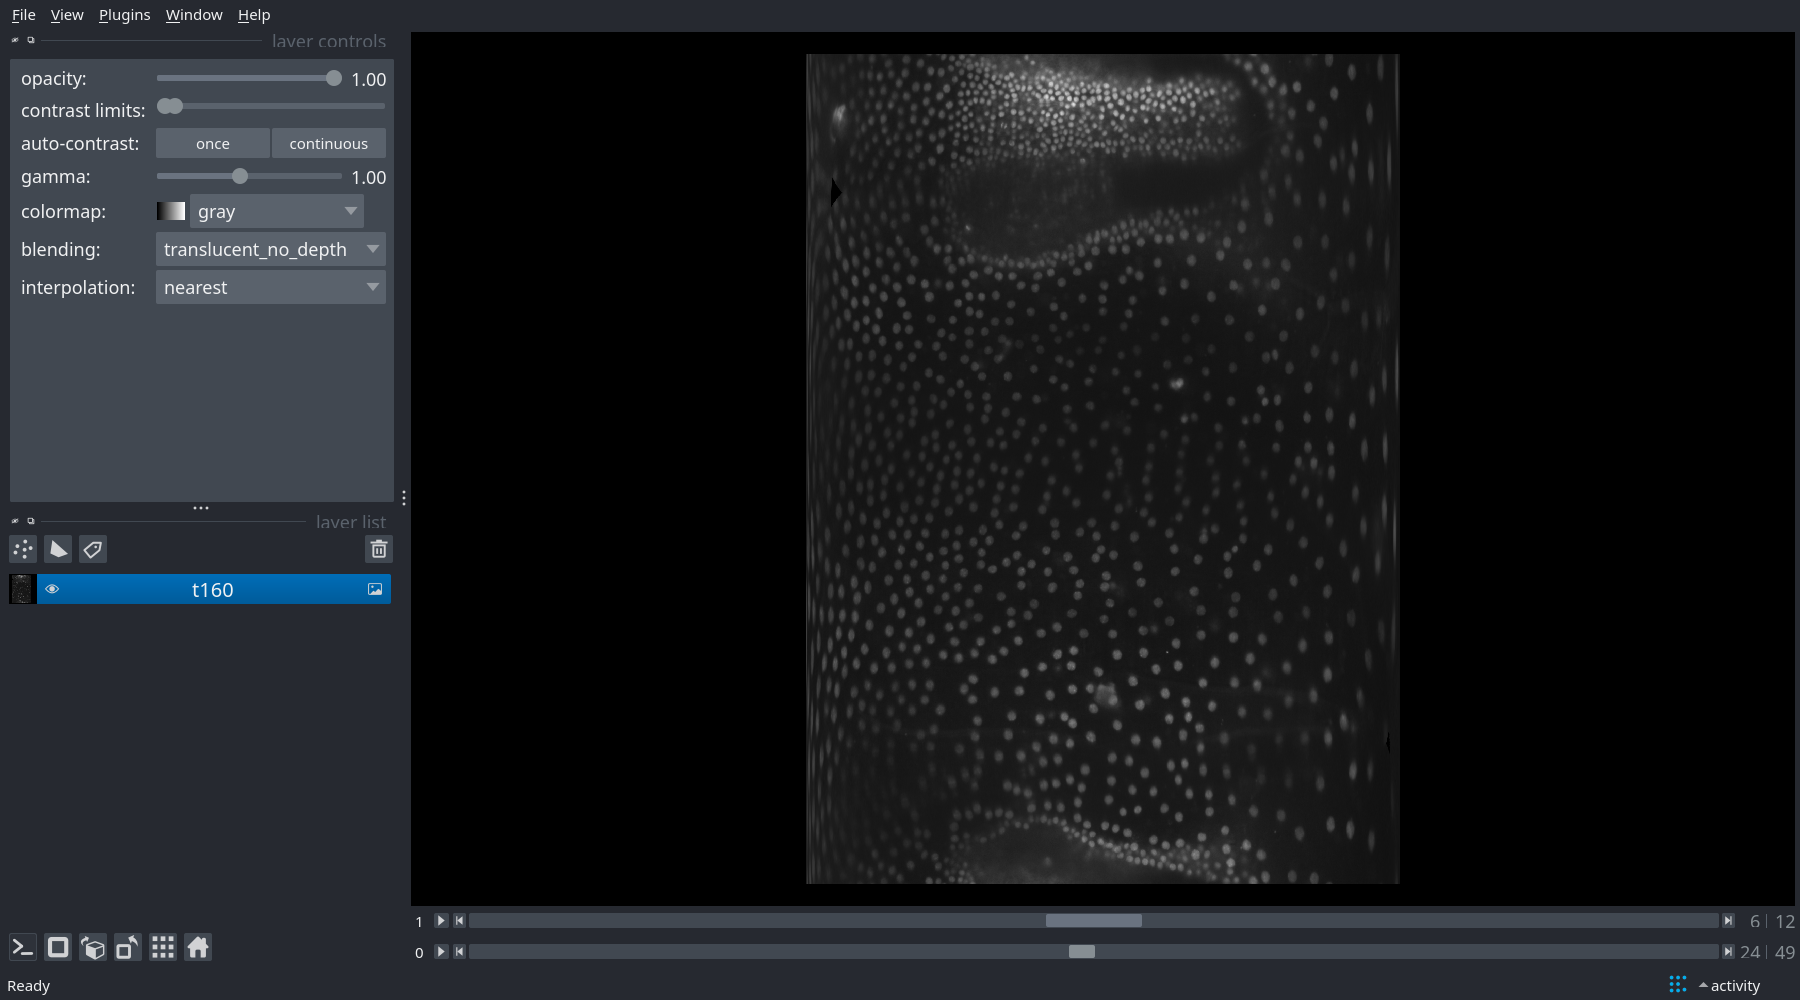

In [3]:
dataset_path = Path("Fluo-N3DL-TRIC/02")
# loading the last 50 frame where interesting happens
im_files = sorted(dataset_path.glob("*.tif"))[-50:]
# im_files = sorted(dataset_path.glob("*.tif"))  # uncomment to run the whole dataset

viewer = napari.Viewer()
viewer.window.resize(1800, 1000)

im_layer = viewer.open(im_files, stack=True)
image = viewer.layers[0].data

nbscreenshot(viewer)

We detect which pixels contains cells and which are background using the `array_apply` function to apply the `detect_foreground` to each individual time point while saving it to the `detection.zarr` path.

Applying detect_foreground ...: 100%|█████████████████████████████████| 50/50 [01:26<00:00,  1.73s/it]


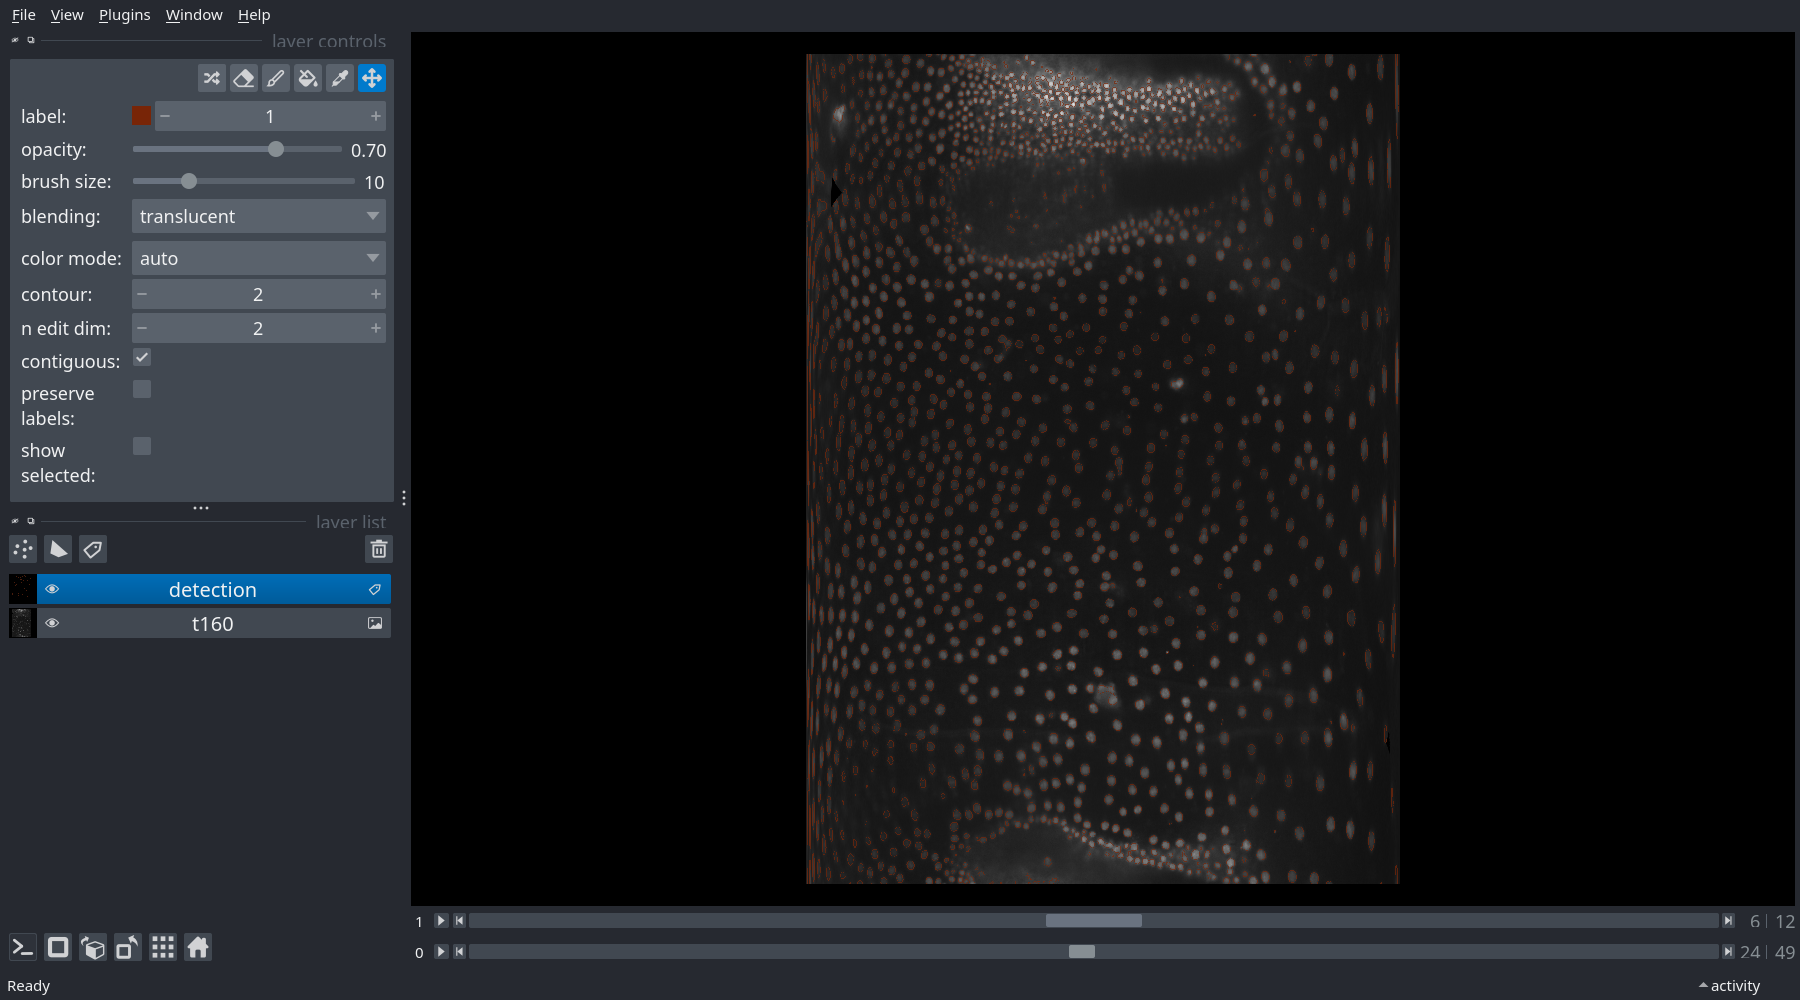

In [4]:
detection = create_zarr(image.shape, bool, path="detection.zarr", overwrite=True)
array_apply(
    func=detect_foreground,
    in_data=image,
    out_data=detection,
)

viewer.add_labels(detection, visible=True).contour = 2

nbscreenshot(viewer)

Ultrack requires an estimate of the cell boundaries, we approximate this by inverting the image using the `robust_invert` function and saving it to `boundaries.zarr`.

In [5]:
boundaries = create_zarr(image.shape, np.float16, path="boundaries.zarr", overwrite=True)
array_apply(
    func=robust_invert,
    in_data=image,
    out_data=boundaries,
)

viewer.add_image(boundaries, visible=False)

Applying robust_invert ...: 100%|█████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]


<Image layer 'boundaries' at 0x7fae7c039780>

Using the original images we compute the movement flow. We use a lower number of `n_scales` because we the `z` dimension is very short, using the default `n_scales=3` results in a zero-length dimension.

In [6]:
!rm -r flow.zarr # removing previous flow
flow = timelapse_flow(image, store_or_path="flow.zarr", n_scales=2)
viewer.add_image(flow, contrast_limits=(-0.001, 0.001), colormap="turbo", visible=False, scale=(4,) * 3, channel_axis=1)

Computing flow:   0%|                                                          | 0/49 [00:00<?, ?it/s]/home/jordao/miniconda3/envs/ultrack-flow-field/lib/python3.10/site-packages/torch/nn/functional.py:4332: UserWarning: Since version 1.3.0, affine_grid behavior has changed for unit-size grids when align_corners=True. This is not an intended use case of affine_grid. See the documentation of affine_grid for details.
  warnings.warn(
Computing flow: 100%|█████████████████████████████████████████████████| 49/49 [04:43<00:00,  5.78s/it]


[<Image layer 'Image' at 0x7fae7c039540>,
 <Image layer 'Image [1]' at 0x7faea28beda0>,
 <Image layer 'Image [2]' at 0x7fae840fed40>]

To evaluate the flow you can advenct through the flow field using the centroids of the connected components of the first frame as the initial conditions.

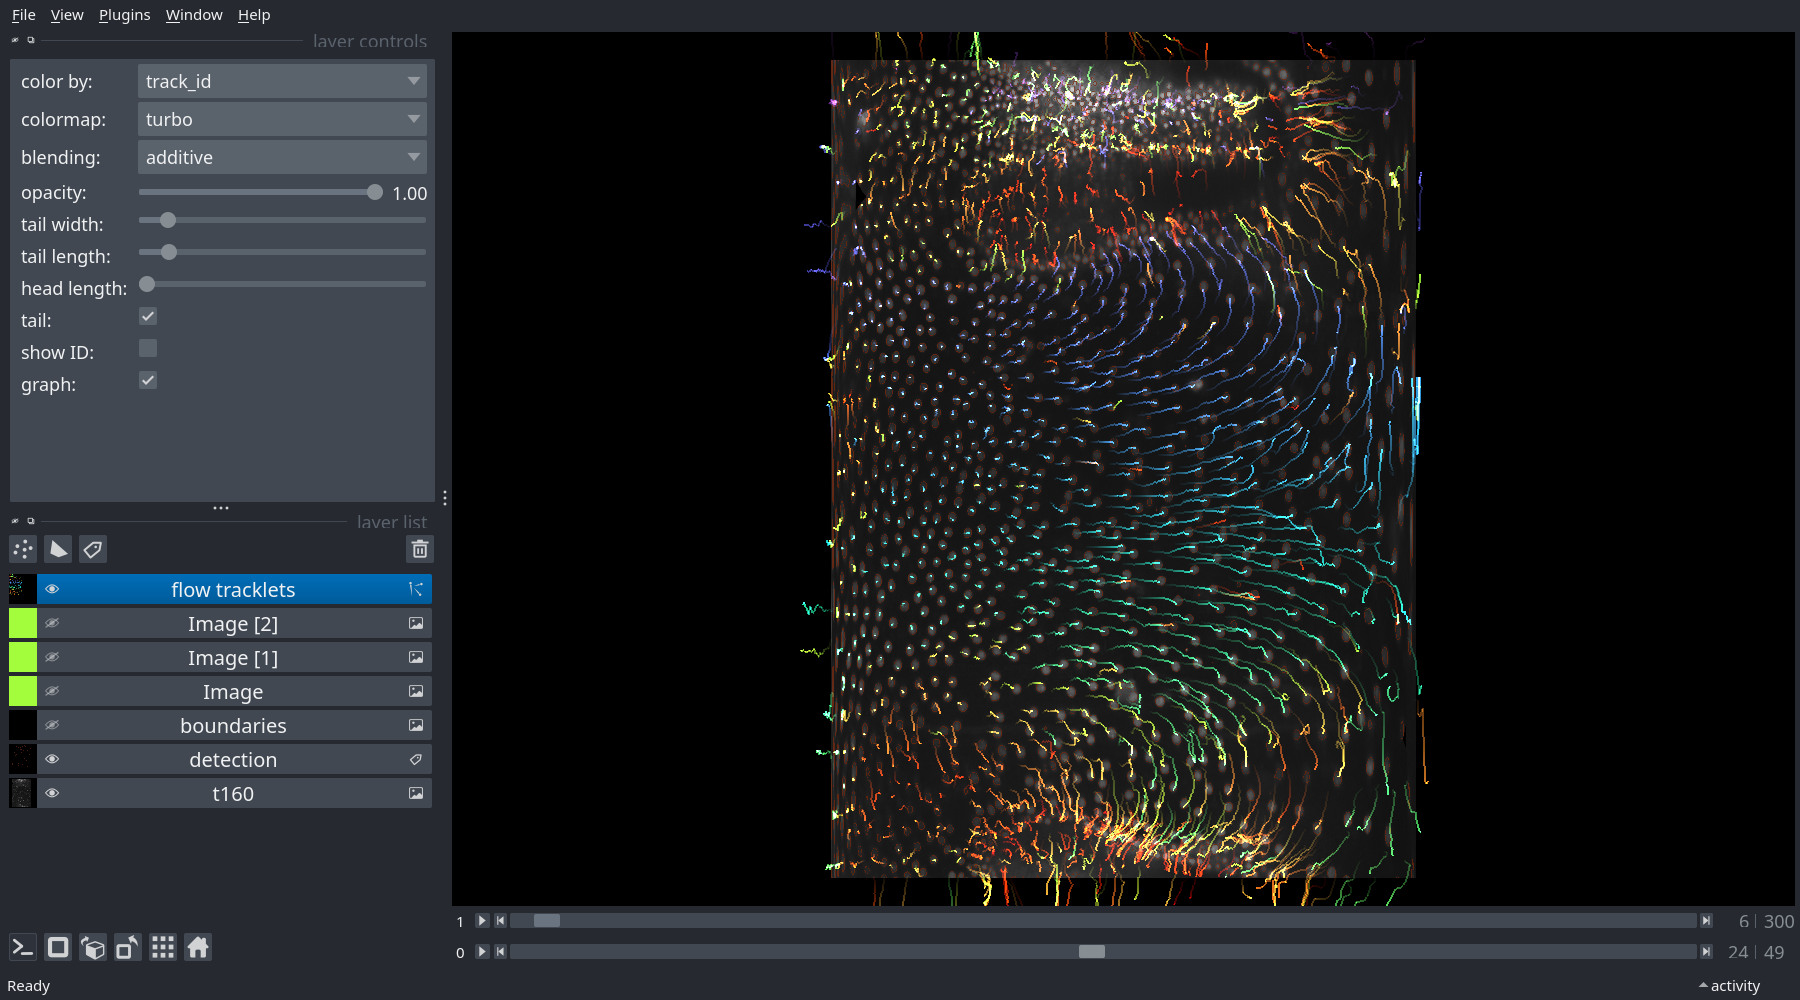

In [7]:
coarse_labels, _ = ndi.label(detection[0])
trajectory = advenct_field_from_labels(flow, coarse_labels)
flow_tracklets = trajectories_to_tracks(trajectory)
viewer.add_tracks(
    flow_tracklets,
    name="flow tracklets",
    visible=True,
    tail_length=25,
)

nbscreenshot(viewer)

Now that we have our `detection`, `boundaries` and `flow`, and have checked that they look ok, we will start the tracking step.
Ultrack's tracking **with flow** relies on 4 steps and their respective python functions:
- `segment`: Computes the segmentation hypothesis for tracking;
- `add_flow`: Adds the flow to each segmentation hypothesis, must be called before `link`;
- `link`: Links and assign edge weights to the segmentation hypothesis taking into consideration the previously added flow;
- `solve`: Solves the tracking problem by selecting the strongly connected segmentation hypothesis.

All of these steps use our configuration object, `MainConfig`, which we'll set up below. It's documentation can be found [here](https://github.com/royerlab/ultrack/blob/main/ultrack/config/README.md).

The parameters were chosen manually by inspection.

NOTE: If you're running out of memory you should decrease the `n_workers` parameters. If you want to speed up the processing and have spare memory you can increase it.

In [8]:
cfg = MainConfig()

cfg.data_config.n_workers = 8

cfg.segmentation_config.n_workers = 8
cfg.segmentation_config.min_area = 1_000
cfg.segmentation_config.max_area = 15_000
cfg.segmentation_config.max_noise = 0.1

cfg.linking_config.n_workers = 8
cfg.linking_config.max_neighbors = 5
cfg.linking_config.max_distance = 50.0

pprint(cfg)

MainConfig(
│   data_config=DataConfig(working_dir=PosixPath('.'), database='sqlite', address=None, n_workers=8),
│   segmentation_config=SegmentationConfig(
│   │   threshold=0.5,
│   │   min_area=1000,
│   │   max_area=15000,
│   │   min_frontier=0.0,
│   │   anisotropy_penalization=0.0,
│   │   max_noise=0.1,
│   │   ws_hierarchy=<function watershed_hierarchy_by_area at 0x7faf1b1c5120>,
│   │   n_workers=8
│   ),
│   linking_config=LinkingConfig(n_workers=8, max_neighbors=5, max_distance=50.0, distance_weight=0.0),
│   tracking_config=TrackingConfig(
│   │   appear_weight=-0.001,
│   │   disappear_weight=-0.001,
│   │   division_weight=-0.001,
│   │   dismiss_weight_guess=None,
│   │   include_weight_guess=None,
│   │   window_size=None,
│   │   overlap_size=1,
│   │   solution_gap=0.001,
│   │   time_limit=36000,
│   │   method=0,
│   │   n_threads=-1,
│   │   link_function='power',
│   │   power=4,
│   │   bias=-0.0
│   )
)

Next, compute the set of candidate segmentation hypothesis from the `detection` and `boundaries` maps.

In [9]:
segment(detection, boundaries, cfg, overwrite=True)

Adding nodes to database:   0%|                                                | 0/50 [00:00<?, ?it/s]/home/jordao/miniconda3/envs/ultrack-flow-field/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/jordao/miniconda3/envs/ultrack-flow-field/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/jordao/miniconda3/envs/ultrack-flow-field/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/jordao/miniconda3/envs/ultrack-flow-field/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subno

Then, we apply the flow to the candidate segmentations.

In [10]:
add_flow(cfg, flow)

100%|█████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.82it/s]


Using the flow information we link nearby segments and assign an association score.

In [11]:
link(cfg, overwrite=True)

Linking nodes.:   0%|                                                          | 0/49 [00:00<?, ?it/s]/home/jordao/miniconda3/envs/ultrack-flow-field/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/jordao/miniconda3/envs/ultrack-flow-field/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/jordao/miniconda3/envs/ultrack-flow-field/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/jordao/miniconda3/envs/ultrack-flow-field/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest sub

Finally, we select which segments have the highest association score while linking them over time.

In [12]:
solve(cfg, overwrite=True)


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2023-08-04
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 1222533 rows, 2492708 columns and 5449993 nonzeros
Model fingerprint: 0x9bf335d6
Variable types: 0 continuous, 2492708 integer (2492708 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-18, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 238043 rows and 303505 columns (presolve time = 5s) ...
Presolve removed 238053 rows and 303554 columns (presolve time = 11s) ...
Presolve removed 293492 rows and 424335 columns
Presolve time: 13.69s
Presolved: 929041 rows, 2068373 columns, 4555304 nonzeros
Found heuristic solution: objective 1197.5158519
Variable

We export the resulting tracks into the napari tracks format and a zarr with the instance segmentation masks.

Exporting segmentation masks:   0%|                                            | 0/50 [00:00<?, ?it/s]/home/jordao/miniconda3/envs/ultrack-flow-field/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/jordao/miniconda3/envs/ultrack-flow-field/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/jordao/miniconda3/envs/ultrack-flow-field/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/jordao/miniconda3/envs/ultrack-flow-field/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subno

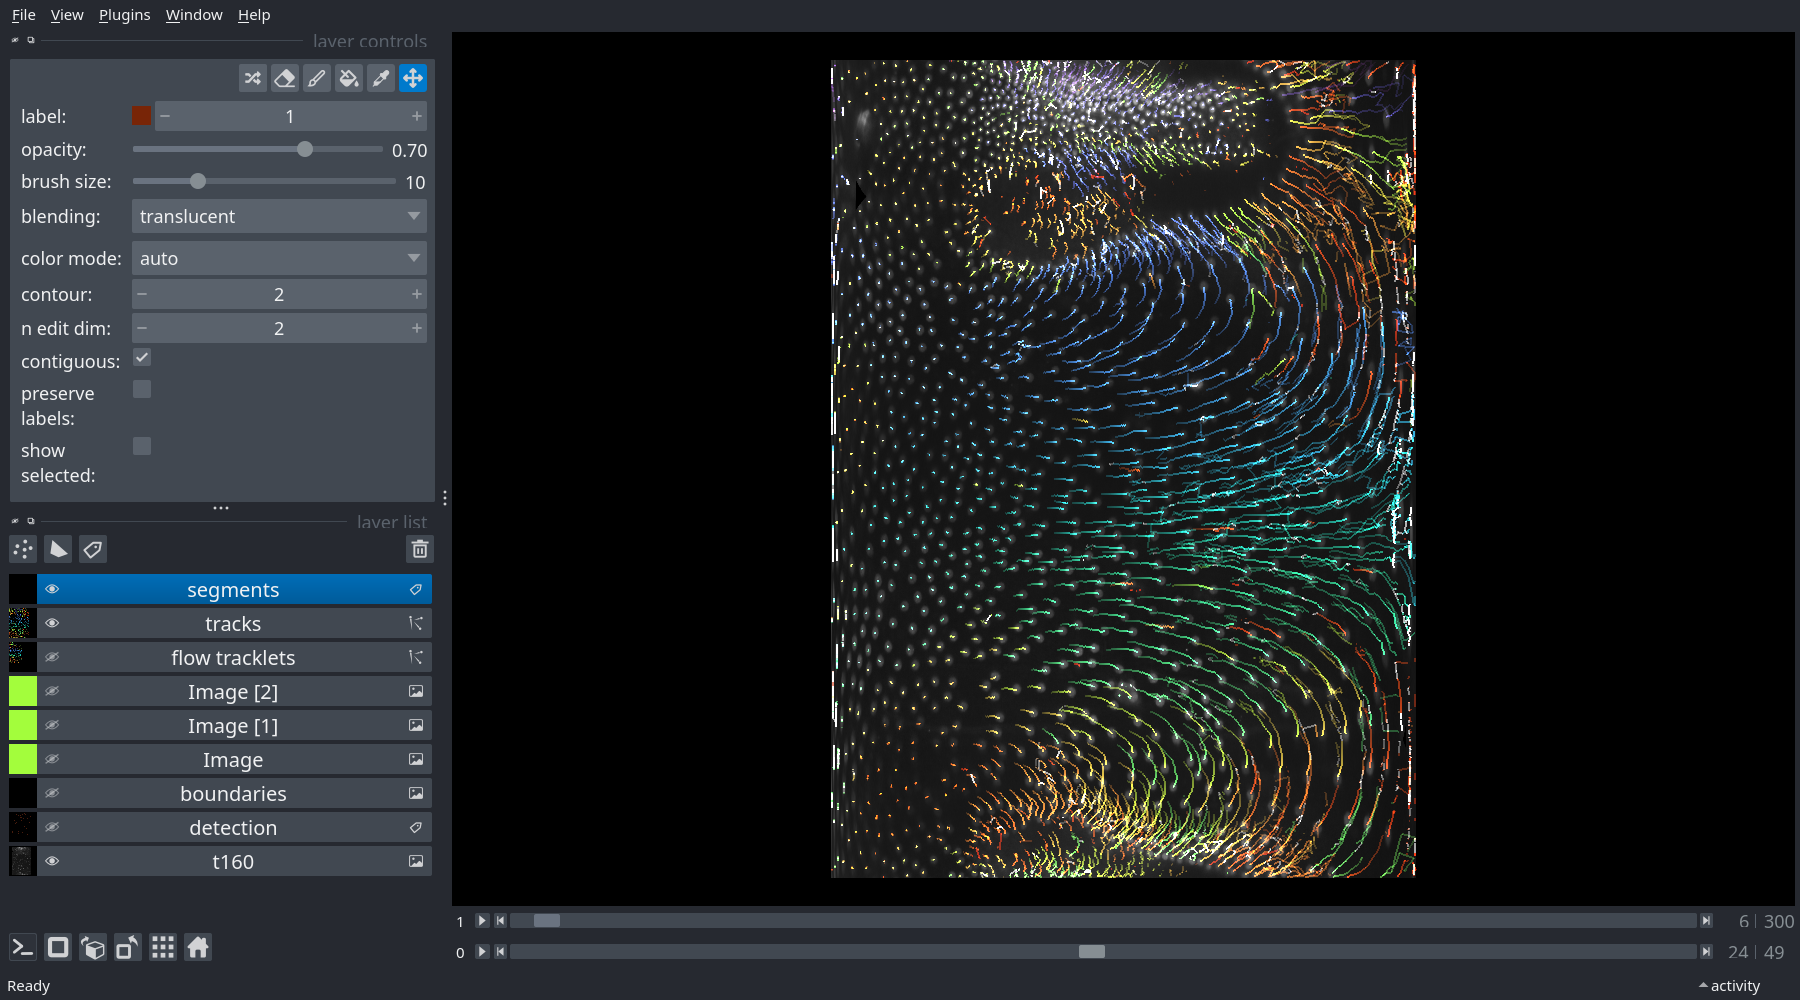

In [13]:
!rm -r segments.zarr  # removing previous segmentation

tracks_df, graph = to_tracks_layer(cfg)
tracks_df.to_csv("tracks.csv", index=False)

segments = tracks_to_zarr(
    cfg,
    tracks_df,
    store_or_path="segments.zarr",
)

viewer.layers["flow tracklets"].visible = False
viewer.layers["detection"].visible = False
viewer.add_tracks(
    tracks_df[["track_id", "t", "z", "y", "x"]],
    name="tracks",
    graph=graph,
    visible=True,
)

viewer.add_labels(da.from_zarr(segments), name="segments").contour = 2

nbscreenshot(viewer)